## Implementation of *Wealth and Wisdom: Unveiling the Contrast between Richness and Science*

### Research Question 1
#### How does the author employ specific words such as "rich", "wealth", "money" and "success" in The Science of Getting Rich to inspire and motivate the reader?


In [33]:
import re
import nltk
import requests
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from scipy.stats import chi2_contingency
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import chi2_contingency
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Source data url
url = 'https://www.gutenberg.org/cache/epub/59844/pg59844.txt'

# Keywords for richness
rich_keywords = ["rich", "richness", "abundance", "wealth", "wealthy", "money", "affluent", "success", "affluence" ]

def fetch_text_from_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        text = response.text[2926:]  # Remove cover and table of contents
        text = re.sub(r'\n|\r', ' ', text)
        return text
    else:
        print(f"Failed to fetch content. Status code: {response.status_code}")
        return None

def preprocess_text(text):
    more_stopwords = ["project", "gutenberg"]
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    stop_words = set(stopwords.words('english') + more_stopwords)
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return filtered_tokens


def identify_sentences(text):
    sentences = sent_tokenize(text)
    return sentences

def analyze_sentiment_with_tfidf(sentences):
    # Create a TF-IDF vectorizer
    vectorizer = TfidfVectorizer()

    # Transform sentences to TF-IDF vectors
    tfidf_matrix = vectorizer.fit_transform(sentences)

    # Extract feature names (words)
    feature_names = vectorizer.get_feature_names_out()

    # Create an empty DataFrame
    results_df = pd.DataFrame(columns=["Sentence", "Sentiment", "TF-IDF Scores"])  # "TF-IDF Scores" is for reference but not applied in the project

    # Initialize the VADER sentiment intensity analyzer
    analyzer = SentimentIntensityAnalyzer()

    for i, sentence in enumerate(sentences):
        # Extract TF-IDF scores for the current sentence
        tfidf_scores = tfidf_matrix[i].toarray().flatten()

        # Analyze sentiment using VADER
        sentiment_scores = analyzer.polarity_scores(sentence)

        # Determine sentiment label
        sentiment_label = 'positive' if sentiment_scores['compound'] >= 0 else 'negative'

        # Create a DataFrame for the current result
        new_row = pd.DataFrame({
            "Sentence": [sentence],
            "Sentiment": [sentiment_label],
            "TF-IDF Scores": [dict(zip(feature_names, tfidf_scores))]
        })
   
        # Concatenate the new row to the existing DataFrame
        results_df = pd.concat([results_df, new_row], axis=0, ignore_index=True)
    return results_df

##### Implementation and Findings

In [34]:
# Fetch book in plain text from url
text = fetch_text_from_url(url)

# Identify and store sentences
sentences = identify_sentences(text)

# Create a DataFrame contain each sentence
df = pd.DataFrame({'Sentences': sentences})
df['contain_rich'] = df['Sentences'].str.contains('|'.join(rich_keywords), case=False, regex=True).astype(int)

# Display the DataFrame
print("Data Preview: Sentences whether contain rich-related words or not")
display(df.head(10))



# Tokenise text for further processing
filtered_tokens = preprocess_text(text)

# Explorative factors
# 1. Count word frequency for words in the "rich" list
rich_word_freq = Counter(word for word in filtered_tokens if word.lower() in rich_keywords)

# 2. Rank word frequency for all words
all_word_freq = FreqDist(tokens)
all_word_rank = {word: rank for rank, (word, _) in enumerate(all_word_freq.most_common(), 1)}

# 3. Analyze_sentiment_with_tfidf
results_df = analyze_sentiment_with_tfidf(sentences)
new_df = pd.concat([results_df[['Sentence', 'TF-IDF Scores']], df['contain_rich'], results_df['Sentiment']], axis=1)

rich_positive = len(new_df[(new_df['contain_rich'] == 1) & (new_df['Sentiment'] == 'positive')])
rich_negative = len(new_df[(new_df['contain_rich'] == 1) & (new_df['Sentiment'] == 'negative')])

pos_cnt = len(new_df[new_df['Sentiment'] == 'positive'])
neg_cnt = len(new_df[new_df['Sentiment'] == 'negative'])

sum_rich = sum(rich_word_freq.values())
words_cnt = len(filtered_tokens)

# Chi-square test for independence
contingency_table = pd.crosstab(new_df['Sentiment'], new_df['contain_rich'].map({0: 'N', 1: 'Y'}))  # map 0, 1 to N, Y for better reability

# Perform chi-squared test of independence
chi2, p, _, _ = chi2_contingency(contingency_table)


Data Preview: Sentences whether contain rich-related words or not


,Sentences,contain_rich
0,PREFACE.,0
1,"This book is pragmatical, not philosophical; a...",0
2,It is intended for the men and women whose mo...,1
3,"It is for those who have, so far, found neithe...",0
4,It is expected that the reader will take the f...,0
5,Every man or woman who does this will certain...,1
6,"For the benefit, however, of those who wish t...",0
7,The monistic theory of the universe--the theor...,0
8,It is the foundation of all the Oriental philo...,0
9,The reader who would dig to the philosophical ...,0


In [61]:
print('Some Facts:')
# Display the results
print(f"1. Rich related words appeared {sum_rich} times over the book of {words_cnt} words.")
print(f"2. There are {rich_positive} sentences contains words related to richness and classified as positive over total {len(new_df)} sentences." )
print(f"3. {pos_cnt} sentences categorised as positive, {pos_cnt/neg_cnt:.1f} times over negative sentences, the book is overall very encouraging.")
print(f"4. Chi-square statistic: {chi2:.1f} and P-value: {p:.3f} to defeat the null hypothesis and indicate there is association between the occurrence of 'rich' words and sentences' sentiment.")
print(f'\n\nPreview of the sentiment analysis and Chi-square contingency table')
display(new_df.head(5))
display(contingency_table)

Some Facts:
1. Rich related words appeared 223 times over the book of 11672 words.
2. There are 190 sentences contains words related to richness and classified as positive over total 976 sentences.
3. 807 sentences categorised as positive, 4.8 times over negative sentences, the book is overall very encouraging.
4. Chi-square statistic: 7.5 and P-value: 0.006 to defeat the null hypothesis and indicate there is association between the occurrence of 'rich' words and sentences' sentiment.


Preview of the sentiment analysis and Chi-square contingency table


,Sentence,TF-IDF Scores,contain_rich,Sentiment
0,PREFACE.,"{'00': 0.0, '000': 0.0, '10': 0.0, '1500': 0.0...",0,positive
1,"This book is pragmatical, not philosophical; a...","{'00': 0.0, '000': 0.0, '10': 0.0, '1500': 0.0...",0,positive
2,It is intended for the men and women whose mo...,"{'00': 0.0, '000': 0.0, '10': 0.0, '1500': 0.0...",1,positive
3,"It is for those who have, so far, found neithe...","{'00': 0.0, '000': 0.0, '10': 0.0, '1500': 0.0...",0,positive
4,It is expected that the reader will take the f...,"{'00': 0.0, '000': 0.0, '10': 0.0, '1500': 0.0...",0,positive


contain_rich,N,Y
Sentiment,,
negative,146,23
positive,617,190


##### Visualising Top 10 Words Appeared in The Science of Getting Rich and Wordcloud

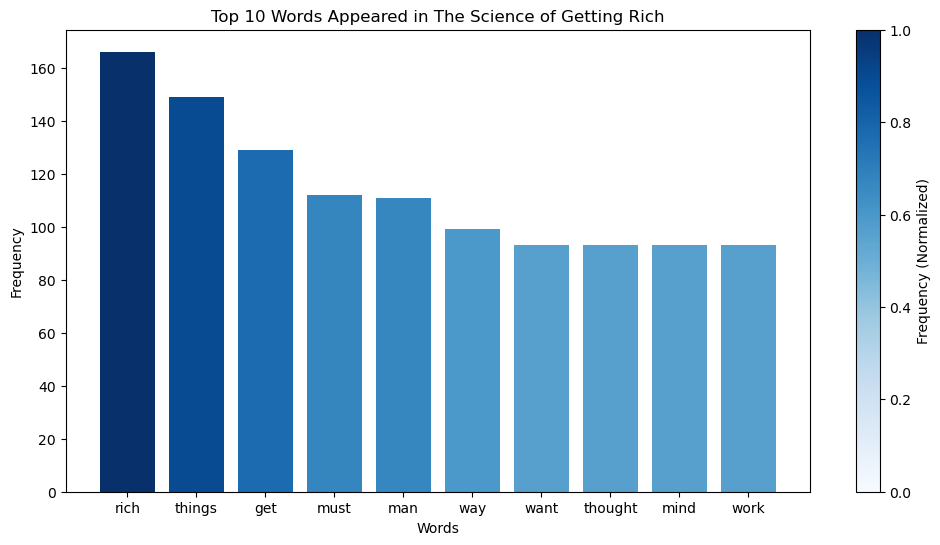

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Create FreqDist for all words
all_word_freq_dist = FreqDist(filtered_tokens)

# Get top 10 words
top_words = all_word_freq_dist.most_common(10)

# Extract words and frequencies
words, frequencies = zip(*top_words)

# Normalize frequencies for color gradient
normalized_frequencies = np.array(frequencies) / max(frequencies)

# Define color gradient using 'Blues'
colors = plt.cm.Blues(normalized_frequencies)

# Create a bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(words, frequencies, color=colors)

# Add labels and title
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Words Appeared in The Science of Getting Rich')

# Add color bar
color_bar = plt.colorbar(plt.cm.ScalarMappable(cmap='Blues'), orientation='vertical')
color_bar.set_label('Frequency (Normalized)')

# Show the plot
plt.show()


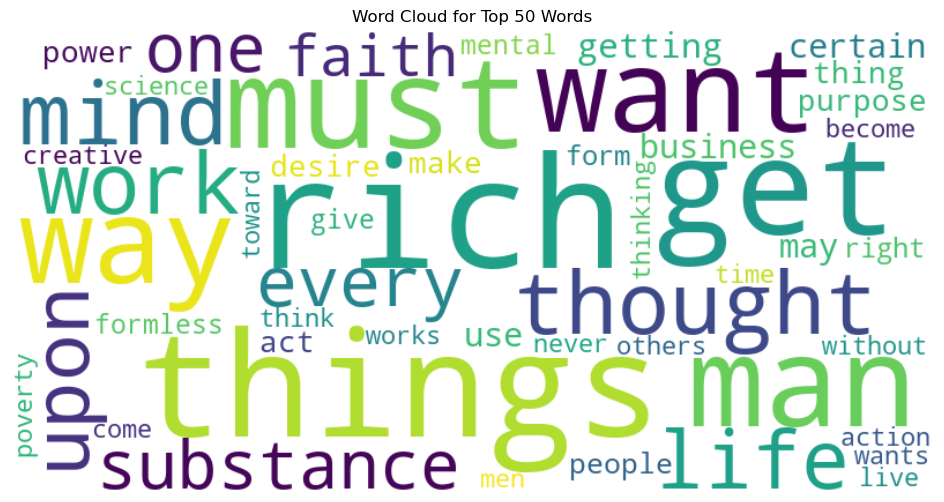

In [58]:
from wordcloud import WordCloud
from nltk import FreqDist
import matplotlib.pyplot as plt
import random


# Set a seed for reproducibility
random_state = random.seed(50)  

# Create FreqDist for all words
all_word_freq_dist = FreqDist(filtered_tokens)

# Get top 100 words
top_words = all_word_freq_dist.most_common(50)

# Create a dictionary from top words for WordCloud
wordcloud_dict = {word: freq for word, freq in top_words}

# Generate WordCloud with a specific seed
wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=random_state).generate_from_frequencies(wordcloud_dict)

# Plot the WordCloud image
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.title('Word Cloud for Top 50 Words')
plt.show()


### Research Question 2
#### IIn what manner does the author use words like "science", "law" and "principle" to establish credibility and present his wealth creation method as a rational and logical system?
##### Topic Modeling


In [136]:
import string

from gensim import corpora, models

# Tokenize words in each sentence and remove stopwords, "project," and "gutenberg"
stop_words = set(stopwords.words('english') +["project", "gutenberg"])
punctuation_chars = set(string.punctuation)


science_keywords = ["science", "sciences", "law", "laws", "principle", "principlse"]
filtered_sentences = [sentence for sentence in sentences if any(keyword in sentence.lower() for keyword in science_keywords)]

tokenized_sentences = []
for sentence in filtered_sentences:
    words = word_tokenize(sentence)
    words = [word.lower() for word in words if word.lower() not in stop_words]
    words = [word.lower() for word in words if word.lower() not in punctuation_chars]
    words = [word.lower() for word in words if word.lower() not in {'“', '”', '’'}]  # Special chars found in topics
    words = list(filter(None, words))
    tokenized_sentences.append(words)

# Create a dictionary and a corpus for topic modeling
dictionary = corpora.Dictionary(tokenized_sentences)
corpus = [dictionary.doc2bow(words) for words in tokenized_sentences]


# Perform Latent Dirichlet Allocation (LDA) for topic modeling with topic pruning
seed = 42
num_topics = 10
alpha = 'auto'  
eta = 'auto'  

lda_model = models.LdaModel(
    corpus,
    num_topics=num_topics,
    id2word=dictionary,
    random_state=seed,
    alpha=alpha,
    eta=eta,
)


# Print topics
topics_strings = []
print("Topics:")
for topic_id, topic in lda_model.print_topics():
    topic_string = " ".join([word.split('*')[1].strip().strip('"') for word in topic.split('+')])
    topics_strings.append(topic_string)
#     print(topic)

for i, topic in enumerate(topics_strings):
    print(i+1, topic)

Topics:
1 laws foundation literary archive states already information mississippi educational tax
2 could science field laws co-operative industries wallace world religion hath
3 science getting rich law work copyright upon states teaches class
4 rich propose end getting science editions hath copyright work law
5 rich law science getting laws like certain may therefore u.s.
6 work things want science rich taking men force robbery principle
7 make science agreement law rich getting use disclaimer two applicable
8 science rich getting true exact every book man people must
9 science rich law getting copyright certain laws get necessary protected
10 man things law must science laws opportunity may located mind


In [135]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.012473 -0.109324       1        1  15.119354
5      0.094923 -0.052506       2        1  14.383379
2      0.047087 -0.059508       3        1  12.500057
4      0.037267  0.054879       4        1  11.883073
9      0.090650  0.051801       5        1  11.489000
6     -0.037942  0.084568       6        1   9.902239
7     -0.041734  0.077240       7        1   7.308265
1     -0.133585 -0.019973       8        1   6.433936
3     -0.068314 -0.044368       9        1   6.146755
0      0.024121  0.017191      10        1   4.833942, topic_info=           Term       Freq      Total Category  logprob  loglift
432  foundation   3.000000   3.000000  Default  30.0000  30.0000
15      science  22.000000  22.000000  Default  29.0000  29.0000
217        make   3.000000   3.000000  Default  28.0000  28.0000
87         laws  10.000000  10.000000  Default  27.0000  27.0000
67       things   7.000000   7.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
518         tax   0.521763   1.845124  Topic10  -4.5035   1.7664
436      states   0.773779   6.554647  Topic10  -4.1094   0.8929
461       state   0.521761   3.756462  Topic10  -4.5035   1.0555
84      certain   0.521753   6.119501  Topic10  -4.5035   0.5675
67       things   0.521744   7.172484  Topic10  -4.5035   0.4087

[516 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
340       7  0.883052        --
502      10  0.904518         3
503      10  0.904518       501
179       7  0.888952      _you
143       1  0.703644  absolute
...     ...       ...       ...
439       3  0.230363     works
229       1  0.527039     world
229       8  0.527039     world
412       3  0.767242     wrote
296       2  0.729746        xv

[534 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 3, 5, 10, 7, 8, 2, 4, 1])